# Comparisons across mQTL sets
1. Heritability of DNAm
1. Significant mQTL
1. Annotations

In [1]:
library(here)
library(data.table)
library(tidyverse)
library(parallel)
library(glue)
library(ggsci)

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [2]:
cross_sex_hits <- fread(here("data","delahaye_richs_marginal_bonf_maf05.txt.gz"))
male_hits <- fread(here("data","delahaye_richs_male_bonf_maf05.txt.gz"))
female_hits <- fread(here("data","delahaye_richs_female_bonf_maf05.txt.gz"))
sex_depedent_hits <- fread(here("data","delahaye_richs_sex_interaction_bonf_maf05.txt.gz"))
cord_blood_hits <- fread("../../ariesmqtl/cord.ALL.M.tab")[`p-value` < (0.05 / .N)]

## Heritability of DNAm

In [3]:
current_heritability < -fread(here("data", "cis_heritability.txt.gz"))

Loading required package: grid

Loading required package: futile.logger



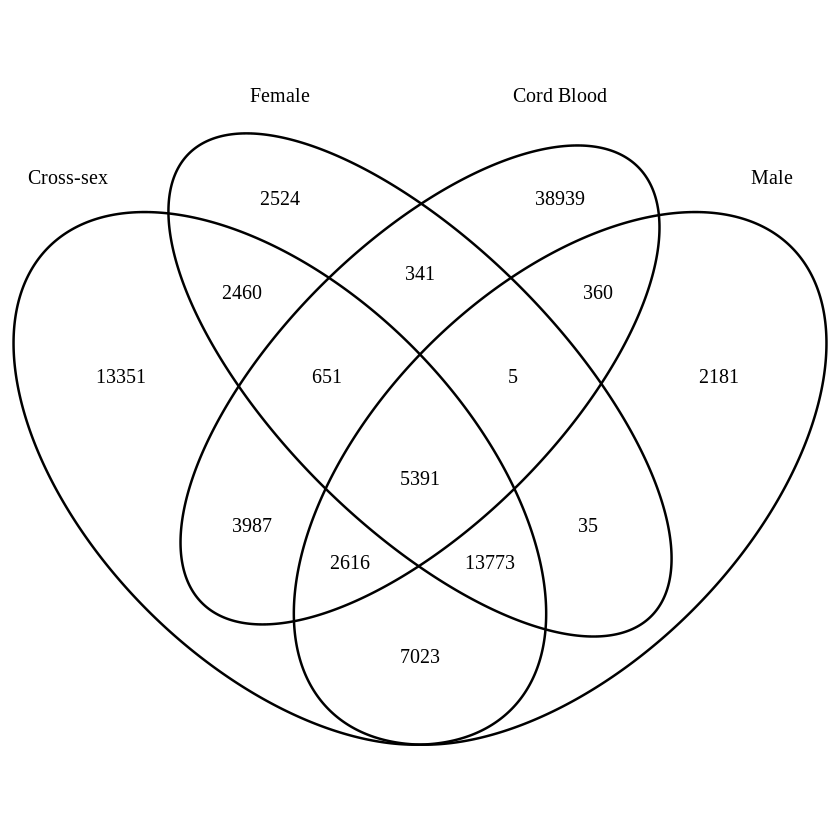

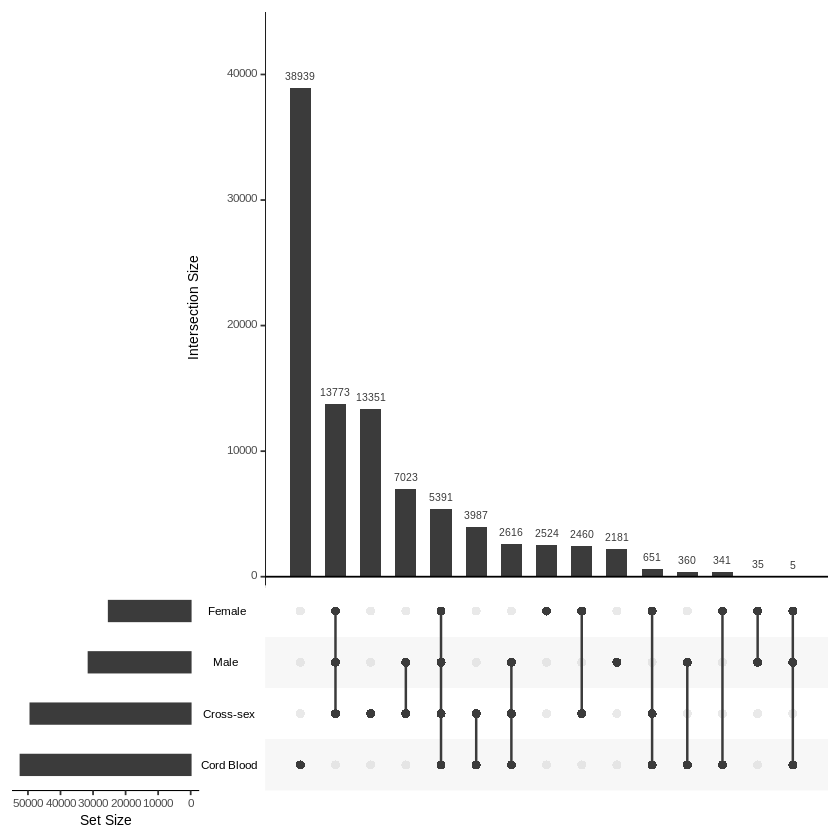

name,value
<chr>,<list>
Cross-sex,28793
Male,18151
Female,14821
Cord blood,33359


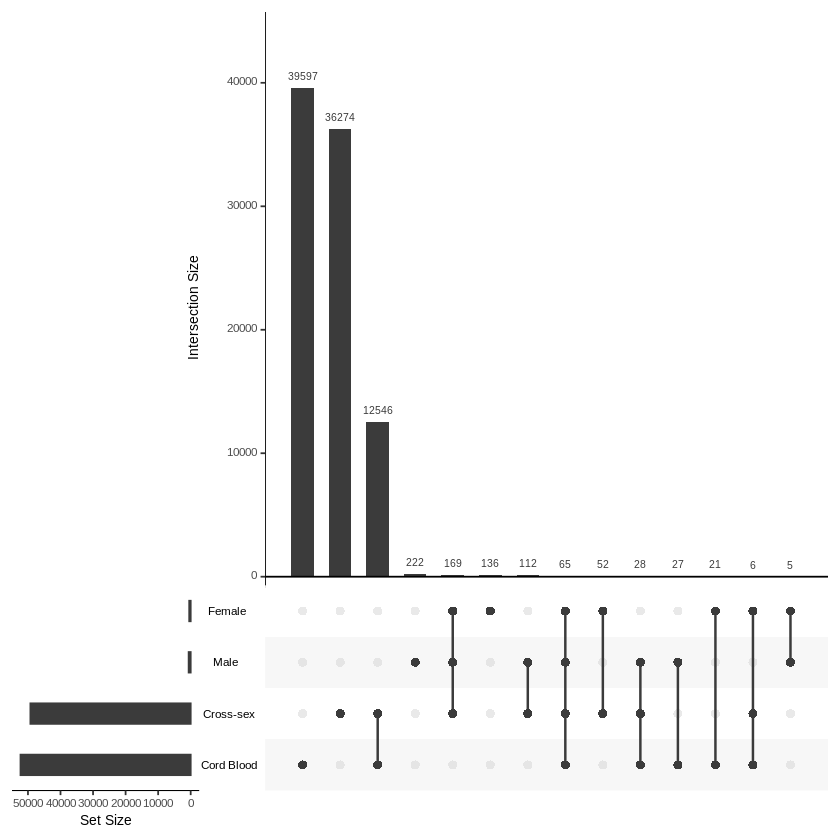

name,value
<chr>,<list>
Cross-sex,28793
Male,412
Female,307
Cord blood,33359


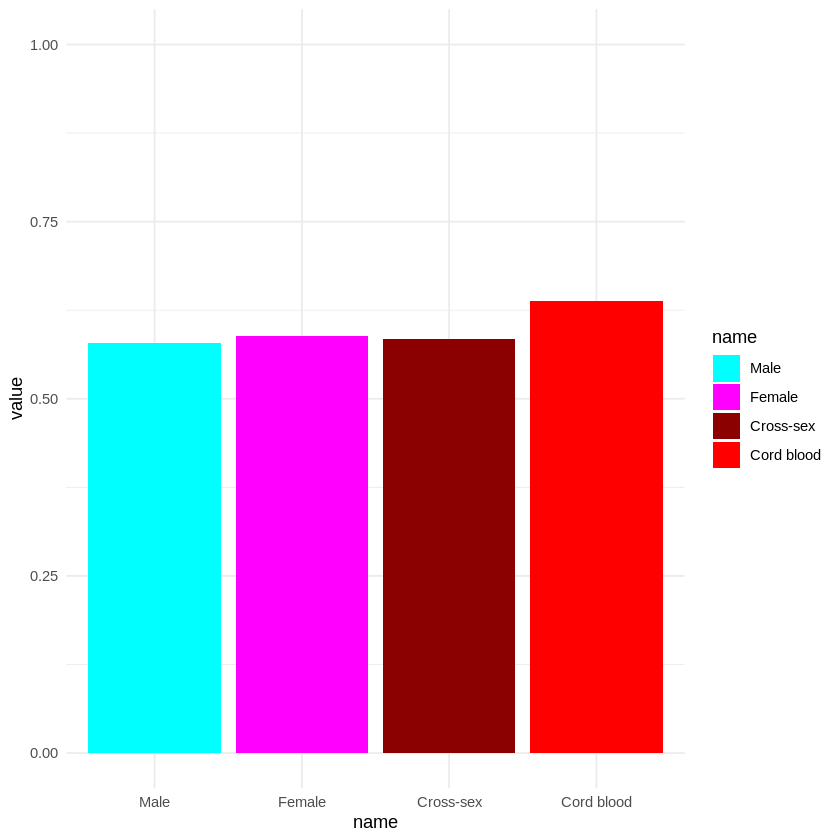

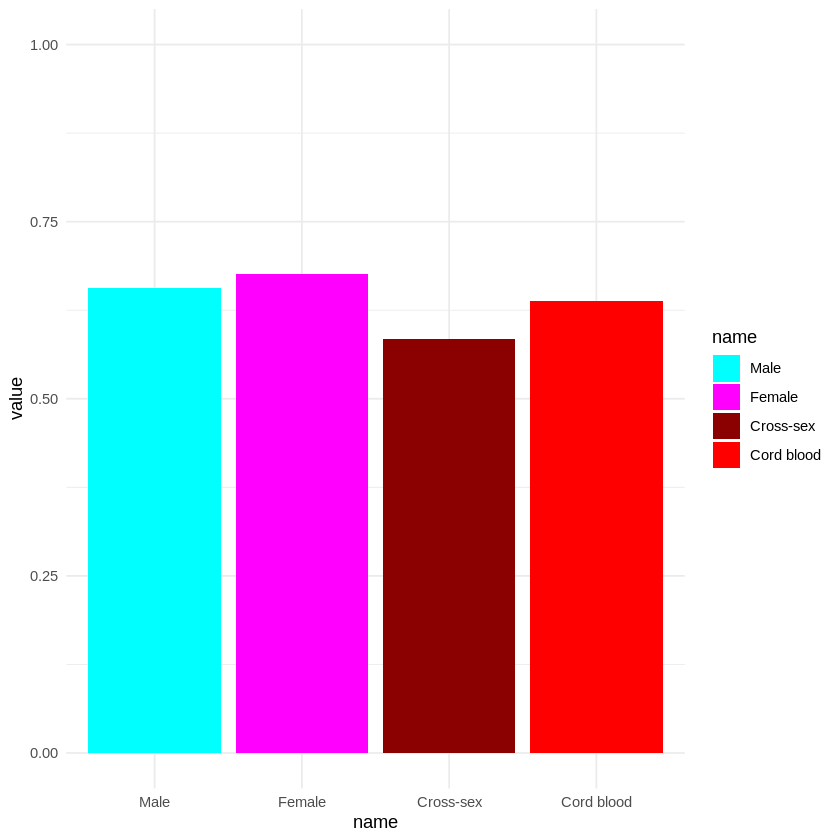

In [4]:
library(VennDiagram)
library(UpSetR)
result <- list(
        "Cross-sex" = cross_sex_hits$Probe,
        "Male" = male_hits$Probe,
        "Female" = female_hits$Probe,
        "Cord Blood" = cord_blood_hits$gene
)
grid.newpage()
p <- venn.diagram(
    filename=NULL,
    x = lapply(result,unique)
)
grid.draw(p)
upset(fromList(lapply(result,unique)),order.by = "freq")

result <- list(
        "Cross-sex" = cross_sex_hits$Probe,
        "Male" = male_hits[Probe %in% sex_depedent_hits$Probe]$Probe,
        "Female" = female_hits[Probe %in% sex_depedent_hits$Probe]$Probe,
        "Cord Blood" = cord_blood_hits$gene
)
upset(fromList(lapply(result,unique)),order.by = "freq")

result <- list(
        "Cross-sex" = cross_sex_hits[Probe %in% current_heritability[`V(G)/Vp` < 0.1]$probe]$Probe,
        "Male" = male_hits[Probe %in% current_heritability[`V(G)/Vp` < 0.1]$probe]$Probe,
        "Female" = female_hits[Probe %in% current_heritability[`V(G)/Vp` < 0.1]$probe]$Probe,
        "Cord blood" = cord_blood_hits[gene %in% current_heritability[`V(G)/Vp` < 0.1]$probe]$gene
)

num_hits <- data.frame(value =c(length(unique(cross_sex_hits$Probe)),
      length(unique(male_hits$Probe)),
      length(unique(female_hits$Probe)),
      length(unique(cord_blood_hits$gene))))
result <- enframe(lapply(lapply(result,unique),length))
result
result$value <- as.numeric(result$value) / as.numeric(num_hits$value)
result$name <- factor(result$name,levels = c("Male", "Female", "Cross-sex", "Cord blood"))
ggplot(result,aes(name,value, fill=name)) + 
    geom_col() + 
    scale_fill_manual(values = c("cyan","magenta","dark red", "red"))+
    coord_cartesian(ylim=c(0,1))+
    theme_minimal()

result <- list(
        "Cross-sex" = cross_sex_hits[Probe %in% current_heritability[`V(G)/Vp` < 0.1]$probe]$Probe,
        "Male" = male_hits[Probe %in% sex_depedent_hits$Probe & Probe %in% current_heritability[`V(G)/Vp` < 0.1]$probe]$Probe,
        "Female" = female_hits[Probe %in% sex_depedent_hits$Probe & Probe %in% current_heritability[`V(G)/Vp` < 0.1]$probe]$Probe,
        "Cord blood" = cord_blood_hits[gene %in% current_heritability[`V(G)/Vp` < 0.1]$probe]$gene
)

num_hits <- data.frame(value =c(length(unique(cross_sex_hits$Probe)),
      length(unique(male_hits[Probe %in% sex_depedent_hits$Probe]$Probe)),
      length(unique(female_hits[Probe %in% sex_depedent_hits$Probe]$Probe)),
      length(unique(cord_blood_hits$gene))))
result <- enframe(lapply(lapply(result,unique),length))
result
result$value <- as.numeric(result$value) / as.numeric(num_hits$value)
result$name <- factor(result$name,levels = c("Male", "Female", "Cross-sex", "Cord blood"))
ggplot(result,aes(name,value, fill=name)) + 
    geom_col() + 
    scale_fill_manual(values = c("cyan","magenta","dark red", "red"))+
    coord_cartesian(ylim=c(0,1))+
    theme_minimal()

## Annotation Comparisons

In [5]:
annotation_nonzero <- function(path,file_pattern){
annots <- rbindlist(mclapply(dir(path,full.names=TRUE,pattern=file_pattern),function(f) fread(f),mc.cores=22))
return(annots[bin_CPP == 1]$SNP)    
}
all_sd_annot <- list()
i <- 1
for(qtl_set in c("male_specific","female_specific","marginal","sex_interaction","male", "female", "cord_mqtl")){
    annot <- "bin_CPP_her"
    annotations <- annotation_nonzero("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/",glue("{qtl_set}_{annot}.*.annot.gz"))
    all_sd_annot[[qtl_set]] <- annotations
}

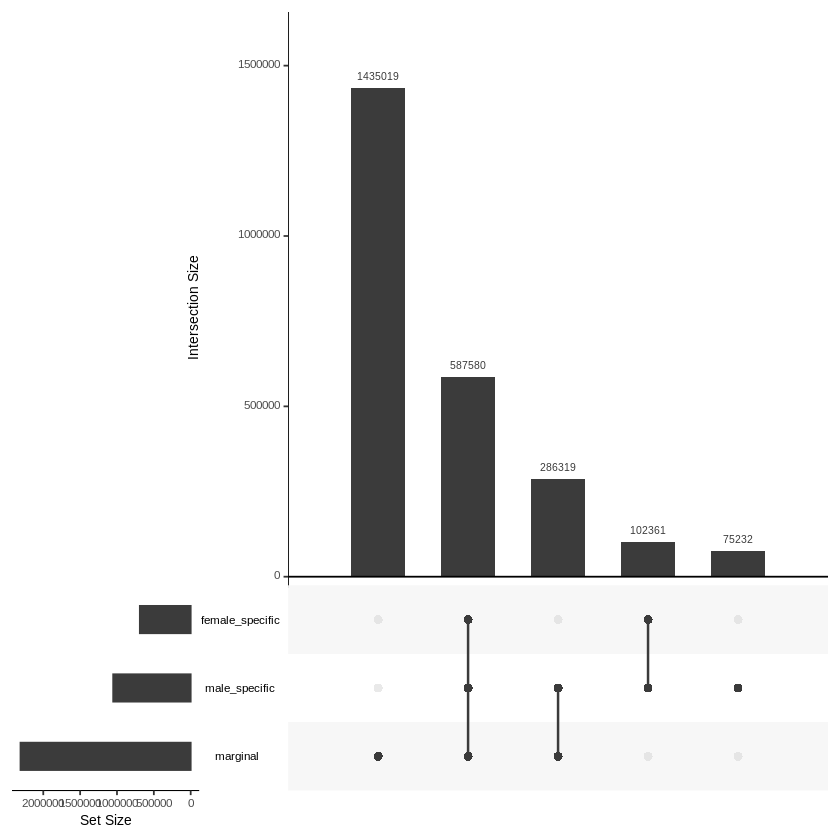

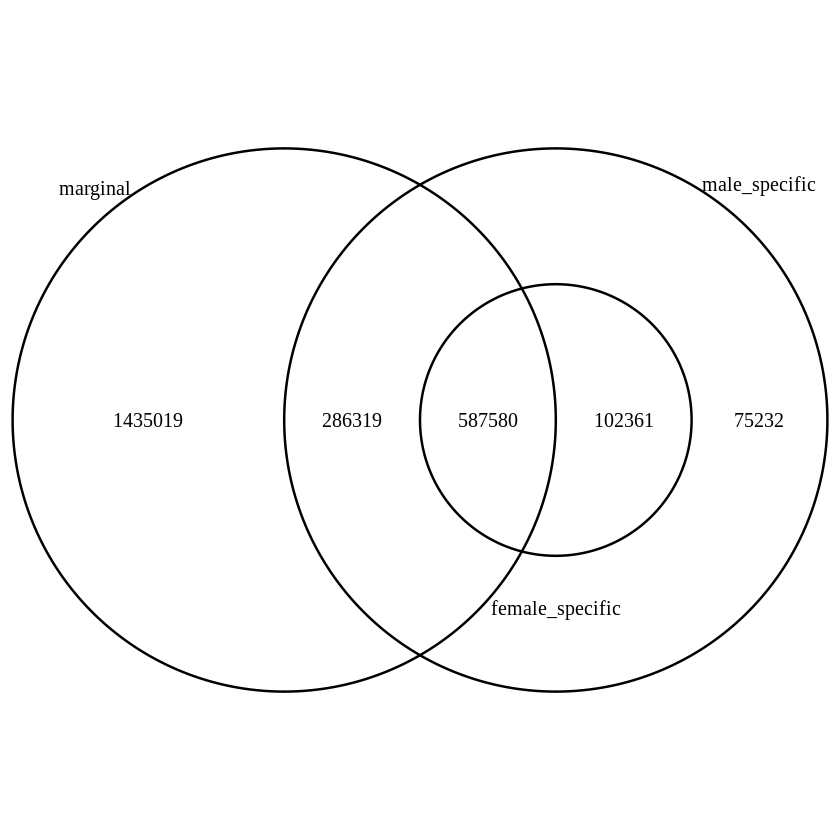

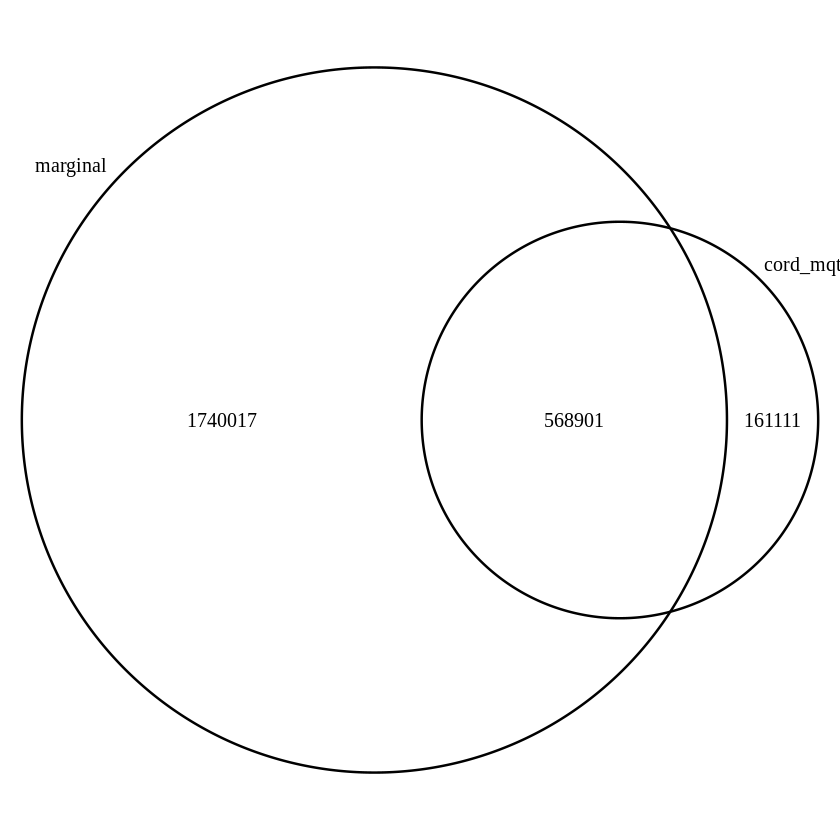

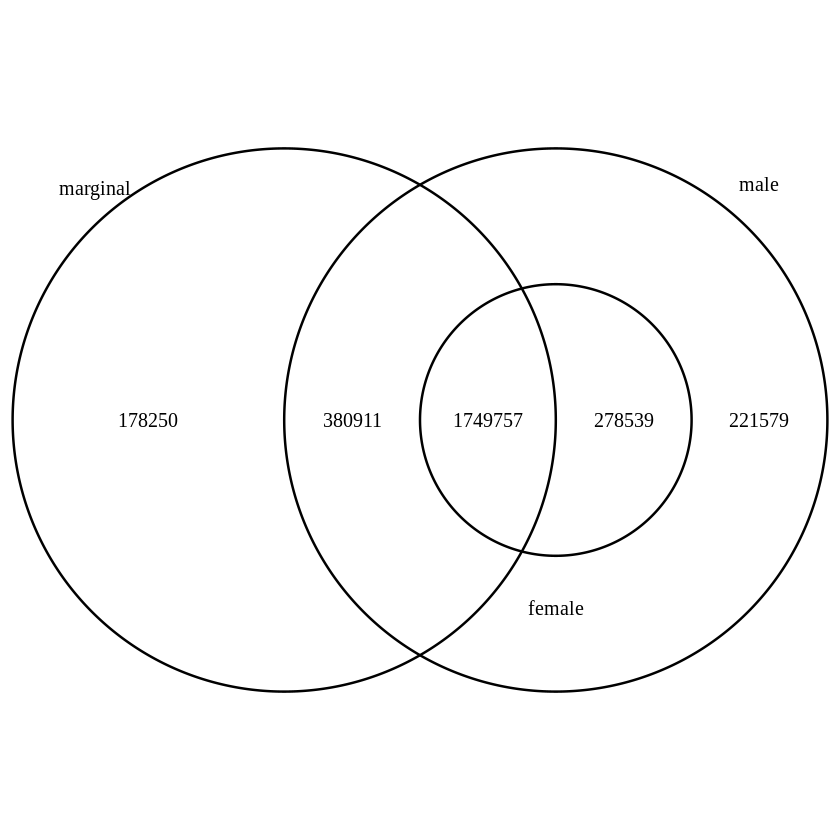

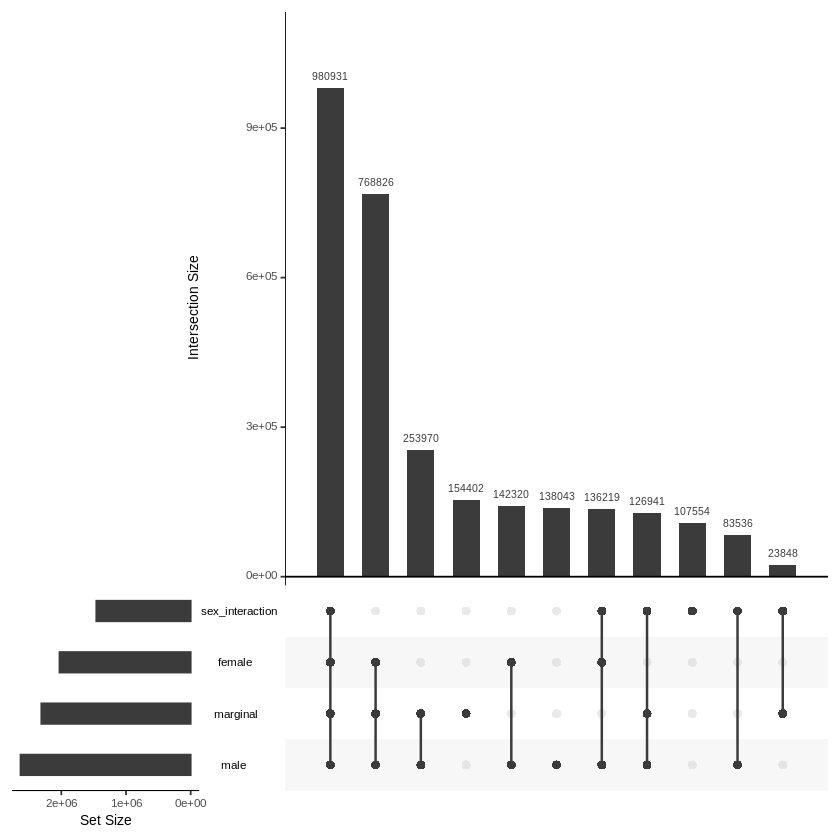

In [16]:
upset(fromList(all_sd_annot[c("male_specific","female_specific","marginal")]),nsets = length(all_sd_annot),order.by = "freq")
grid.newpage()
p <- venn.diagram(
    filename=NULL,
    x = all_sd_annot[c("male_specific","female_specific","marginal")]
)
grid.draw(p)

grid.newpage()
p <- venn.diagram(
    filename=NULL,
    x = all_sd_annot[c("marginal","cord_mqtl")]
)
grid.draw(p)


grid.newpage()
p <- venn.diagram(
    filename=NULL,
    x = all_sd_annot[c("male","female","marginal")]
)
grid.draw(p)

upset(fromList(all_sd_annot[c("male","female","marginal","sex_interaction")]),order.by="freq")